In [ ]:
import os
from obspy import read
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq
import pandas as pd
from obspy import read
from obspy.signal.filter import highpass
import librosa
from obspy.signal.detrend import simple as detrend_simple

### Thống kê data

In [83]:
FOLDER_PATH = "./waveform_instrument"

total_files = 0
total_traces = 0
total_duration = 0.0
start_times = []
end_times = []
global fileName
channel_counter = Counter()

for filename in os.listdir(FOLDER_PATH):
    if filename.endswith(".mseed") or filename.endswith(".miniseed"):
        fileName = filename
        filename = filename
        total_files += 1
        file_path = os.path.join(FOLDER_PATH, filename)
        try:
            stream = read(file_path)
            total_traces += len(stream)
            for trace in stream:
                stats = trace.stats
                duration = stats.endtime - stats.starttime
                total_duration += duration
                start_times.append(stats.starttime)
                end_times.append(stats.endtime)
                channel_counter[stats.channel] += 1
        except Exception as e:
            print(f"Lỗi đọc file {filename}: {e}")

print(f"Tổng số file: {total_files}")
print(f"Tổng số trace: {total_traces}")
print(f"Tổng thời lượng tín hiệu: {total_duration / 3600:.2f} giờ ({total_duration:.0f} giây)")

if start_times and end_times:
    earliest = min(start_times)
    latest = max(end_times)
    print(f"Khoảng thời gian dữ liệu: {earliest.date} đến {latest.date}")

print("\nPhân bố kênh tín hiệu:")
for ch, count in channel_counter.items():
    print(f"  {ch}: {count} trace")

Tổng số file: 1080
Tổng số trace: 2200
Tổng thời lượng tín hiệu: 716.94 giờ (2580969 giây)
Khoảng thời gian dữ liệu: 2025-05-16 đến 2025-05-16

Phân bố kênh tín hiệu:
  BHZ: 2200 trace


### Thông số mỗi mẫu

In [71]:
st = read(f"{FOLDER_PATH}/{fileName}")
print(f"File Name: {fileName}")

print(st)

for tr in st:
    print(f"Trạm: {tr.stats.station}")
    print(f"Kênh: {tr.stats.channel}")
    print(f"Thời gian bắt đầu: {tr.stats.starttime}")
    print(f"Thời gian kết thúc: {tr.stats.endtime}")
    print(f"Số mẫu: {tr.stats.npts}")
    print(f"Tần số lấy mẫu: {tr.stats.sampling_rate}")
    print("----")

print("Tổng số kênh:", len(st))
print("Tổng số mẫu:", st.count())

File Name: ZRO_BHZ.mseed
1 Trace(s) in Stream:
AV.ZRO..BHZ | 2025-05-16T04:18:51.000000Z - 2025-05-16T04:58:51.000000Z | 50.0 Hz, 120001 samples
Trạm: ZRO
Kênh: BHZ
Thời gian bắt đầu: 2025-05-16T04:18:51.000000Z
Thời gian kết thúc: 2025-05-16T04:58:51.000000Z
Số mẫu: 120001
Tần số lấy mẫu: 50.0
----
Tổng số kênh: 1
Tổng số mẫu: 1


# Step 2 Preprocessing Data

## Plot Data

### Before preprocess

Found file: ./waveform_instrument\121A_BHZ.mseed
         network: SC
         station: 121A
        location: 
         channel: BHZ
       starttime: 2025-05-16T04:22:26.000000Z
         endtime: 2025-05-16T05:02:26.000000Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 96001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 1685, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 862720})
Số điểm: 96001
Giá trị min/max: -0.00 / 0.00
Trung bình: 0.00


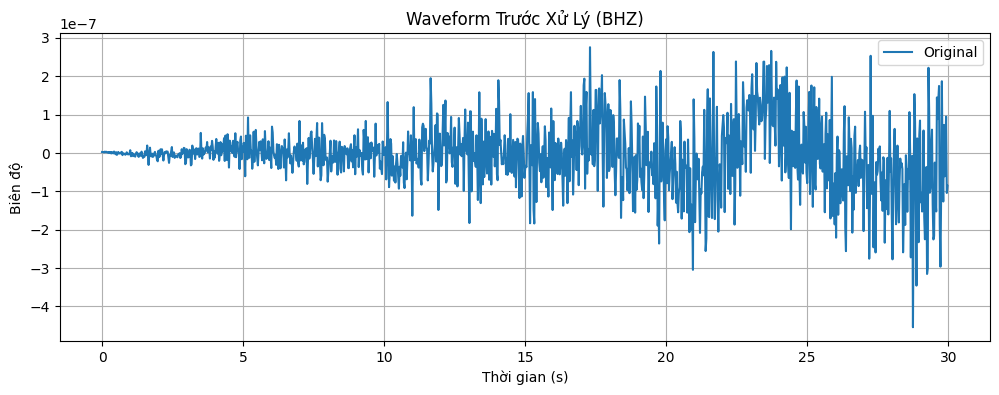

In [84]:
file_path = None
for f in os.listdir(f"{FOLDER_PATH}"):
    if f.endswith(".mseed") or f.endswith(".miniseed"):
        file_path = os.path.join(f"{FOLDER_PATH}", f)
        print(f"Found file: {file_path}")
        break

stream = read(file_path)
stream = stream.select(channel="BHZ")

if len(stream) == 0:
    raise ValueError("No trace BHZ find in file")

trace = stream[0]

print(trace.stats)
print(f"Số điểm: {len(trace.data)}")
print(f"Giá trị min/max: {np.min(trace.data):.2f} / {np.max(trace.data):.2f}")
print(f"Trung bình: {np.mean(trace.data):.2f}")

plt.figure(figsize=(12, 4))
t = trace.times()
max_samples = int(trace.stats.sampling_rate * 30)
plt.plot(t[:max_samples], trace.data[:max_samples], label="Original")
plt.title("Waveform Trước Xử Lý (BHZ)")
plt.xlabel("Thời gian (s)")
plt.ylabel("Biên độ")
plt.grid(True)
plt.legend()
plt.show()

### After preprocess

Found file: 121A_BHZ.mseed
Original trace info:          network: SC
         station: 121A
        location: 
         channel: BHZ
       starttime: 2025-05-16T04:22:26.000000Z
         endtime: 2025-05-16T05:02:26.000000Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 96001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 1685, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 862720})


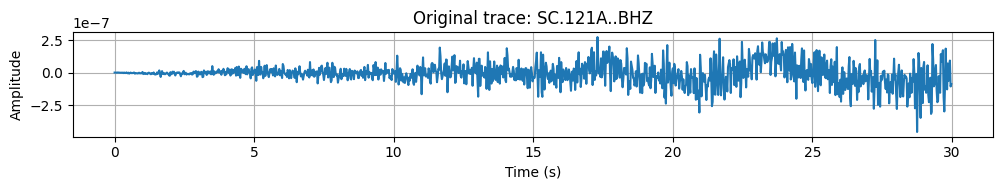

Trace duration: 2400.03 s


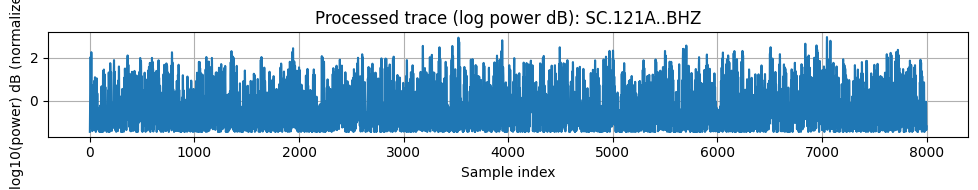

In [87]:
waveform_folder = FOLDER_PATH
target_sampling_rate = 100
duration_sec = 80

# === Tìm file đầu tiên trong thư mục ===
fname = None
name = None
for f in os.listdir(waveform_folder):
    if f.lower().endswith((".mseed", ".miniseed")):
        fname = f
        name = f
        print(f"Found file: {fname}")
        break

if fname is None:
    raise FileNotFoundError("Không tìm thấy file .mseed hoặc .miniseed trong thư mục.")

# === Đọc dữ liệu ===
stream = read(os.path.join(waveform_folder, fname))
processed_traces = []

for tr in stream:
    print("Original trace info:", tr.stats)

    try:
        # --- Hiển thị 30 giây đầu ---
        plt.figure(figsize=(10, 2))
        t = tr.times()
        max_samples = int(min(30, tr.stats.npts / tr.stats.sampling_rate) * tr.stats.sampling_rate)
        plt.plot(t[:max_samples], tr.data[:max_samples])
        plt.title(f"Original trace: {tr.id}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"Trace duration: {tr.stats.npts / tr.stats.sampling_rate:.2f} s")

        # --- Resample nếu cần ---
        if tr.stats.sampling_rate != target_sampling_rate:
            tr.resample(target_sampling_rate)

        # --- Lấy đạo hàm bậc 1 ---
        tr.data = np.gradient(tr.data, 1 / tr.stats.sampling_rate)

        # --- Detrend ---
        tr.detrend("demean")
        tr.detrend("linear")

        # --- Lọc bandpass ---
        tr.filter("bandpass", freqmin=0.5, freqmax=10.0, corners=4, zerophase=True)

        # --- Cắt đoạn giữa ---
        n_samples = int(duration_sec * tr.stats.sampling_rate)
        if len(tr.data) < n_samples:
            print(f"Skipping {tr.id}: shorter than {duration_sec} seconds")
            continue

        start_sample = len(tr.data) // 2 - n_samples // 2
        end_sample = start_sample + n_samples
        tr.data = tr.data[start_sample:end_sample]

        # --- Tính log-power ---
        data = tr.data.astype(np.float32)
        power = data ** 2
        epsilon = 1e-12
        log_power = 10 * np.log10(power + epsilon)

        # --- Chuẩn hóa ---
        log_power -= np.mean(log_power)
        log_power /= np.std(log_power)

        processed_traces.append(log_power)

        # --- Hiển thị kết quả ---
        plt.figure(figsize=(10, 2))
        plt.plot(log_power)
        plt.title(f"Processed trace (log power dB): {tr.id}")
        plt.xlabel("Sample index")
        plt.ylabel("log10(power) dB (normalized)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing trace {tr.id}: {e}")

In [88]:
folder = "datas_intrument"
os.makedirs(f"{folder}", exist_ok=True)

process_name = ""
print(name)

for fname in os.listdir(FOLDER_PATH):
    if not fname.lower().endswith((".mseed", ".miniseed")):
        continue

    print(f"Processing file: {fname}")

    try:
        stream = read(os.path.join(FOLDER_PATH, fname))
    except Exception as e:
        print(f"  Error reading {fname}: {e}")
        continue

    for tr in stream:
        try:
            # --- Resample ---
            if tr.stats.sampling_rate != 100:
                tr.resample(100)

            # --- Gradient (velocity → acceleration) ---
            tr.data = np.gradient(tr.data, 1 / tr.stats.sampling_rate)

            # --- Detrend ---
            tr.detrend("demean")
            tr.detrend("linear")

            # --- Lọc bandpass ---
            tr.filter("bandpass", freqmin=0.5, freqmax=10.0, corners=4, zerophase=True)

            # --- Cắt đoạn giữa ---
            n_samples = int(duration_sec * tr.stats.sampling_rate)
            if len(tr.data) < n_samples:
                print(f"  Trace {tr.id} skipped: shorter than {duration_sec}s")
                continue

            start_sample = len(tr.data) // 2 - n_samples // 2
            end_sample = start_sample + n_samples
            tr.data = tr.data[start_sample:end_sample]

            # --- Tính log-power ---
            data = tr.data.astype(np.float32)
            power = data ** 2
            epsilon = 1e-12
            log_power = 10 * np.log10(power + epsilon)

            # --- Chuẩn hóa ---
            log_power -= np.mean(log_power)
            log_power /= np.std(log_power)

            processed_traces.append(log_power)

            # --- Lưu file ---
            trace_id = tr.id.replace(".", "_")
            start_time = tr.stats.starttime.strftime("%Y%m%dT%H%M%S")
            output_name = f"{trace_id}_{start_time}.npy"
            np.save(os.path.join(folder, output_name), log_power)

            if fname == name:
                print("Found the file")
                process_name = output_name

            print(f"  Saved: {output_name}")

        except Exception as e:
            print(f"  Error processing trace {tr.id}: {e}")

print("All traces processed and saved to 'datas/'")

121A_BHZ.mseed
Processing file: 121A_BHZ.mseed
Found the file
  Saved: SC_121A__BHZ_20250516T042226.npy
Processing file: 214A_BHZ.mseed
  Saved: AE_214A__BHZ_20250516T042218.npy
Processing file: 435B_BHZ.mseed
  Saved: TX_435B__BHZ_20250516T042251.npy
Processing file: A21K_BHZ.mseed
  Saved: AK_A21K__BHZ_20250516T041848.npy
Processing file: AASB_BHZ.mseed
  Saved: BK_AASB_00_BHZ_20250516T042136.npy
Processing file: AC01_BHZ.mseed
  Saved: C1_AC01__BHZ_20250516T042729.npy
Processing file: AC04_BHZ.mseed
  Saved: C1_AC04__BHZ_20250516T042729.npy
Processing file: AC05_BHZ.mseed
  Saved: C1_AC05__BHZ_20250516T042728.npy
Processing file: AC06_BHZ.mseed
  Saved: C1_AC06__BHZ_20250516T042729.npy
Processing file: AC07_BHZ.mseed
  Saved: C1_AC07__BHZ_20250516T042729.npy
Processing file: ACCN_BHZ.mseed
  Saved: LD_ACCN__BHZ_20250516T042211.npy
Processing file: ADAG_BHZ.mseed
  Saved: AV_ADAG__BHZ_20250516T041814.npy
Processing file: ADAM_BHZ.mseed
  Saved: BK_ADAM_00_BHZ_20250516T042132.npy
Proc

C:\Users\anhnh\AppData\Local\Temp\ipykernel_24772\1731562674.py:53: RuntimeWarning: invalid value encountered in divide
  log_power /= np.std(log_power)


  Saved: JP_JTU__BHZ_20250516T041257.npy
Processing file: JWT_BHZ.mseed
  Saved: JP_JWT__BHZ_20250516T041340.npy
Processing file: JYT_BHZ.mseed
  Saved: JP_JYT__BHZ_20250516T041415.npy
Processing file: K13K_BHZ.mseed
  Saved: AK_K13K__BHZ_20250516T041844.npy
Processing file: K15K_BHZ.mseed
  Saved: AK_K15K__BHZ_20250516T041852.npy
Processing file: K24K_BHZ.mseed
  Saved: AK_K24K__BHZ_20250516T041926.npy
Processing file: KAAM_BHZ.mseed
  Saved: GE_KAAM__BHZ_20250516T041413.npy
Processing file: KAB2_BHZ.mseed
  Saved: AV_KAB2__BHZ_20250516T041917.npy
Processing file: KABU_BHZ.mseed
  Saved: AV_KABU__BHZ_20250516T041916.npy
Processing file: KAHG_BHZ.mseed
  Saved: AV_KAHG__BHZ_20250516T041918.npy
Processing file: KAI_BHZ.mseed
  Saved: AK_KAI__BHZ_20250516T041940.npy
Processing file: KAKN_BHZ.mseed
  Saved: AV_KAKN__BHZ_20250516T041917.npy
Processing file: KARE_BHZ.mseed
  Saved: BK_KARE_00_BHZ_20250516T042146.npy
Processing file: KAUT_BHZ.mseed
  Saved: CC_KAUT__BHZ_20250516T042107.npy
P

In [89]:
print(process_name)

SC_121A__BHZ_20250516T042226.npy


# Step 3: Features extraction Mel-Spectrogram

In [76]:
input_dir = folder
output_dir = "melspect_intrument"
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(input_dir) if f.endswith(".npy")]

for fname in files:
    filepath = os.path.join(input_dir, fname)
    print(f"Processing: {fname}")

    try:
        data = np.load(filepath)
        sr = 100

        mel_spec = librosa.feature.melspectrogram(
            y=data,
            sr=sr,
            n_fft=256,
            hop_length=64,
            n_mels=128,
            power=2.0
        )

        # log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=1.0)

        if log_mel_spec.shape[1] < 128:
            pad_width = 128 - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
        elif log_mel_spec.shape[1] > 128:
            log_mel_spec = log_mel_spec[:, :128]

        out_path = os.path.join(output_dir, fname)
        np.save(out_path, log_mel_spec)

        print(f"  Saved: {out_path}")

    except Exception as e:
        print(f"  Error processing {fname}: {e}")

Processing: 2O_BTL01_00_BHZ_20250516T041551.npy
  Saved: melspect_intrument\2O_BTL01_00_BHZ_20250516T041551.npy
Processing: 2O_BTL02_00_BHZ_20250516T041558.npy
  Saved: melspect_intrument\2O_BTL02_00_BHZ_20250516T041558.npy
Processing: 2O_BTL04_00_BHZ_20250516T041601.npy
  Saved: melspect_intrument\2O_BTL04_00_BHZ_20250516T041601.npy
Processing: 2O_BTL06_00_BHZ_20250516T041608.npy
  Saved: melspect_intrument\2O_BTL06_00_BHZ_20250516T041608.npy
Processing: 2O_BTL08_00_BHZ_20250516T041611.npy
  Saved: melspect_intrument\2O_BTL08_00_BHZ_20250516T041611.npy
Processing: 2O_BTL09_00_BHZ_20250516T041608.npy
  Saved: melspect_intrument\2O_BTL09_00_BHZ_20250516T041608.npy
Processing: 2O_BTL10_00_BHZ_20250516T041612.npy
  Saved: melspect_intrument\2O_BTL10_00_BHZ_20250516T041612.npy
Processing: AE_214A__BHZ_20250516T042218.npy
  Saved: melspect_intrument\AE_214A__BHZ_20250516T042218.npy
Processing: AF_POGA__BHZ_20250516T041954.npy
  Saved: melspect_intrument\AF_POGA__BHZ_20250516T041954.npy
Proc

File: melspect_intrument/SC_121A__BHZ_20250516T042226.npy


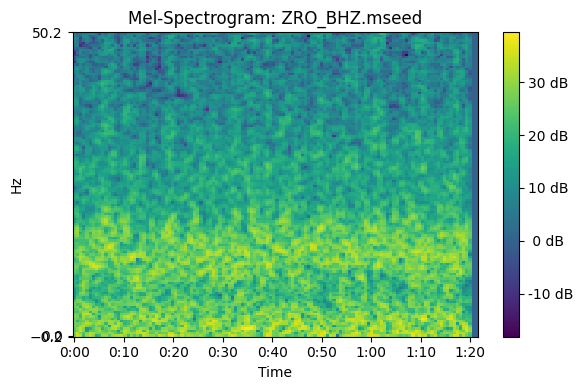

In [90]:
mel_dir = output_dir

# for fname in os.listdir(mel_dir):
#     if fname.endswith(".npy"):
#         filepath = os.path.join(mel_dir, fname)
#         print(f"Đang hiển thị: {fname}")
#         break

fileName = os.path.join(f"{mel_dir}/{process_name}")

if (os.path.exists(fileName)):
    file_path = fileName
    print(f"File: {file_path}")

    data = np.load(file_path)

if data.shape != (128, 128):
    raise ValueError(f"Data in wrong shape: {data.shape}")

plt.figure(figsize=(6, 4))
librosa.display.specshow(data, sr=100, hop_length=64, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%2.0f dB')
plt.title(f"Mel-Spectrogram: {fname}")
plt.tight_layout()
plt.show()

# Step 4: Find the cutoff frequency and label the data

In [92]:
waveform_folder = FOLDER_PATH
file_name = 'label_intrument.csv'
sampling_rate = 100
duration_sec = 80
f_hp_candidates = np.round(np.linspace(0.1, 10.0, 20), 2)
results = []

# --- Hàm tính SNR RMS cải tiến ---
def compute_snr_rms_adaptive(data, sr, threshold_ratio=3, win_sec=20, fade_sec=2):
    win_samples = int(win_sec * sr)
    fade_samples = int(fade_sec * sr)

    # RMS năng lượng trượt
    energy = np.convolve(data**2, np.ones(win_samples) / win_samples, mode='same')

    # Ngưỡng phát hiện onset
    noise_level = np.median(energy)
    threshold = threshold_ratio * noise_level
    onset_index = np.argmax(energy > threshold)

    # Loại bỏ trường hợp onset bất thường
    if onset_index <= fade_samples or onset_index + win_samples + fade_samples >= len(data):
        return 0

    # Noise và Signal windows
    noise = data[max(0, onset_index - win_samples - fade_samples): onset_index - fade_samples]
    signal = data[onset_index + fade_samples: onset_index + fade_samples + win_samples]

    if len(noise) == 0 or len(signal) == 0 or np.std(noise) < 1e-8:
        return 0

    # Tính SNR log10
    snr_linear = np.sqrt(np.mean(signal**2)) / (np.sqrt(np.mean(noise**2)) + 1e-10)
    return np.log10(snr_linear + 1e-10)

# --- Hàm tìm f_hp tốt nhất ---
def find_best_fhp(trace, min_diff=0.05):
    best_snr = -np.inf
    best_fhp = f_hp_candidates[0]
    sr = trace.stats.sampling_rate

    # Tiền xử lý: loại bỏ trend và taper
    data = detrend_simple(trace.data)
    data *= np.hanning(len(data))

    for f_hp in f_hp_candidates:
        if f_hp >= sr / 2 - 1:  # tránh aliasing
            continue
        try:
            filtered = highpass(data, freq=f_hp, df=sr, corners=2, zerophase=True)
            snr = compute_snr_rms_adaptive(filtered, sr)

            # Chọn nếu SNR tốt hơn rõ rệt
            if snr > best_snr + min_diff:
                best_snr = snr
                best_fhp = f_hp

            print(f"  f_hp = {f_hp:.2f}, logSNR = {snr:.3f}")
        except Exception as e:
            print(f"  Error at f_hp={f_hp}: {e}")

    return best_fhp

# --- Duyệt toàn bộ file ---
for fname in os.listdir(waveform_folder):
    if not fname.endswith(".mseed"):
        continue
    try:
        stream = read(os.path.join(waveform_folder, fname))
        for tr in stream:
            if tr.stats.npts < duration_sec * tr.stats.sampling_rate:
                continue
            best_fhp = find_best_fhp(tr)
            results.append({
                "filename": fname,
                "station": tr.stats.station,
                "channel": tr.stats.channel,
                "best_fhp": best_fhp
            })
            print(f"{fname} - {tr.id}: Best f_hp = {best_fhp:.2f} Hz")
    except Exception as e:
        print(f"Error processing {fname}: {e}")

# --- Lưu kết quả ---
df = pd.DataFrame(results)
df.to_csv(file_name, sep=";", index=False)
print(f"Saved label file: {file_name}")

Error processing 121A_BHZ.mseed: name 'detrend_simple' is not defined
Error processing 214A_BHZ.mseed: name 'detrend_simple' is not defined
Error processing 435B_BHZ.mseed: name 'detrend_simple' is not defined
Error processing A21K_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AASB_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AC01_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AC04_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AC05_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AC06_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AC07_BHZ.mseed: name 'detrend_simple' is not defined
Error processing ACCN_BHZ.mseed: name 'detrend_simple' is not defined
Error processing ADAG_BHZ.mseed: name 'detrend_simple' is not defined
Error processing ADAM_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AF01_BHZ.mseed: name 'detrend_simple' is not defined
Error processing AHB

KeyboardInterrupt: 

In [86]:
import pandas as pd
import os

input_csv = "label_intrument.csv"
mel_folder = mel_dir
output_csv = "dataset_intrument.csv"

label_df = pd.read_csv(f"{input_csv}", sep=";")
label_df["key"] = label_df["station"] + "_" + label_df["channel"]

dataset = []

for fname in os.listdir(mel_folder):
    if not fname.endswith(".npy"):
        continue

    try:
        parts = fname.split("_")
        station = parts[1]
        channel = parts[3].split(".")[0]
        key = f"{station}_{channel}"

        matched = label_df[label_df["key"] == key]
        # if(fname == "AV_WEBT__BHZ_20250516T041854.npy"):
        #     print(f"fname: {fname}")
        #     print(f"parts: {parts}")
        #     print(f"Station: {station}")
        #     print(f"Channel: {channel}")
        #     print(f"Key: {key}")
        #     print(f"Matched: {matched}")
            
        if not matched.empty:
            label = float(matched["best_fhp"].values[0])
            dataset.append({
                "filename": fname,
                "label": label
            })
        else:
            print(f"Error fname: {fname}")

    except Exception as e:
        print(f"Error parsing {fname}: {e}")

df_out = pd.DataFrame(dataset)
df_out.to_csv(output_csv, index=False, sep=";")
print(f"Saved: {output_csv}")


Saved: dataset_intrument.csv


# Step 5: Deep Learning model

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader, random_split
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# # ======================
# # Config
# # ======================
# DATA_DIR = "melspec_test"
# LABEL_FILE = "dataset.csv"
# BATCH_SIZE = 32
# EPOCHS = 50
# LEARNING_RATE = 1e-3
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# VAL_SPLIT = 0.2
# TEST_SPLIT = 0.1
# SEED = 42
# torch.manual_seed(SEED)

# # ======================
# # Dataset
# # ======================
# class EarthquakeDataset(Dataset):
#     def __init__(self, data_dir, label_file):
#         self.data_dir = data_dir
#         self.labels = pd.read_csv(label_file, sep=";")
#         self.filenames = self.labels["filename"].str.replace(".mseed", ".npy")

#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         file = self.filenames.iloc[idx]
#         filepath = os.path.join(self.data_dir, file)
#         mel = np.load(filepath).astype(np.float32)  # (128, 128)

#         if mel.shape != (128, 128):
#             raise ValueError(f"Invalid shape {mel.shape} for file {file}")

#         mel_tensor = torch.tensor(mel).unsqueeze(0)  # (1, 128, 128)
#         label = torch.tensor(self.labels.iloc[idx]["best_fhp"], dtype=torch.float32).unsqueeze(0)
#         return mel_tensor, label

# # ======================
# # Model
# # ======================
# class CutoffRegressorCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # (16, 64, 64)
#             nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # (32, 32, 32)
#             nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # (64, 16, 16)
#         )
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * 16 * 16, 256),
#             nn.ReLU(),
#             nn.Linear(256, 1)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         return self.fc(x)

# # ======================
# # Train / Evaluate
# # ======================
# def train_model(model, loader, optimizer, criterion):
#     model.train()
#     total_loss = 0
#     for x, y in loader:
#         x, y = x.to(DEVICE), y.to(DEVICE)
#         optimizer.zero_grad()
#         y_pred = model(x)
#         loss = criterion(y_pred, y)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * x.size(0)
#     return total_loss / len(loader.dataset)

# def eval_model(model, loader, criterion):
#     model.eval()
#     total_loss = 0
#     y_true, y_pred = [], []
#     with torch.no_grad():
#         for x, y in loader:
#             x, y = x.to(DEVICE), y.to(DEVICE)
#             pred = model(x)
#             loss = criterion(pred, y)
#             total_loss += loss.item() * x.size(0)
#             y_true.extend(y.cpu().numpy())
#             y_pred.extend(pred.cpu().numpy())
#     return total_loss / len(loader.dataset), np.array(y_true), np.array(y_pred)

# # ======================
# # Main
# # ======================
# def main():
#     # Load dataset
#     full_dataset = EarthquakeDataset(DATA_DIR, LABEL_FILE)
#     total_len = len(full_dataset)
#     val_len = int(VAL_SPLIT * total_len)
#     test_len = int(TEST_SPLIT * total_len)
#     train_len = total_len - val_len - test_len
#     train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

#     train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
#     val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
#     test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

#     model = CutoffRegressorCNN().to(DEVICE)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     criterion = nn.MSELoss()

#     # Training loop
#     train_losses, val_losses = [], []
#     for epoch in range(EPOCHS):
#         train_loss = train_model(model, train_loader, optimizer, criterion)
#         val_loss, _, _ = eval_model(model, val_loader, criterion)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#         print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#     # Evaluate
#     test_loss, y_true, y_pred = eval_model(model, test_loader, criterion)
#     r2 = r2_score(y_true, y_pred)
#     rmse = mean_squared_error(y_true, y_pred, squared=False)
#     mae = mean_absolute_error(y_true, y_pred)

#     print(f"\nTest MSE Loss: {test_loss:.4f}")
#     print(f"R² Score: {r2:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"MAE: {mae:.4f}")

#     # Plot loss
#     plt.figure(figsize=(8, 5))
#     plt.plot(train_losses, label="Train Loss")
#     plt.plot(val_losses, label="Val Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("MSE Loss")
#     plt.title("Training Loss Curve")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig("loss_curve.png")
#     plt.show()

#     # Save model
#     torch.save(model.state_dict(), "cutoff_predictor.pth")
#     print("Model saved to cutoff_predictor.pth")

# if __name__ == "__main__":
#     main()
